## Textual Analysis Final Project (ECE590.06)

    Aaron Williams
    Due 12-16-2018

In [10]:
#Imports!!
import numpy as np
import nltk
from nltk.corpus import movie_reviews
nltk.download('movie_reviews')

import matplotlib.pyplot as plt
import string

import tensorflow as tf

# I am Running this on a home GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Zenaardvark\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [5]:
#Grab Data
data = [(list(movie_reviews.words(fileid)), category)
        for category in movie_reviews.categories()
        for fileid in movie_reviews.fileids(category)]

In [19]:
#Check if any particular word is punctuation
def not_punc(word):
    if word in string.punctuation:
        return False
    return True

#Check if any particular word is a number
def not_numb(word):
    try:
        num = float(word)
    except ValueError:
        return True
    return False

#We are filtering out numbers and punctuation
clean_data = []

for item in data:
    
    word_list = []
    stemmed_list = []
    
    for word in item[0]:
        if not_punc(word) and not_numb(word):
            word_list.append(word)
    
    clean_data.append((word_list,item[1]))
    
    

In [115]:
#Let's do a training and a test set!
np.random.shuffle(clean_data)

#Let's set a 60 - 40 split on the data!
split = int(len(clean_data)*0.6)
training_data = clean_data[:split]
test_data = [x[0] for x in clean_data[split:]]
test_labels = [x[1] for x in clean_data[split:]]
print(len(training_data))
print(len(test_data))

1200
800


In [162]:
#Let's build up functions for finding accuracy and building roc curves
def form_roc(logits):
    accuracy = 0.
    tpr = [0,0]
    fpr = [0,0]
    for point, logit in enumerate(logits):
        #Collects values for both accuracy and roc curves
        if test_labels[point] == 'pos':
            tpr[1] += 1
            if logit > 0:
                tpr[0] += 1
                accuracy += 1/len(logits)
        elif test_labels[point] == 'neg':
            fpr[1] += 1
            if logit < 0:
                accuracy += 1/len(logits)
            if logit > 0:
                fpr[0] += 1
                
    return accuracy, tpr[0]/tpr[1], fpr[0]/fpr[1]

def get_results(logits):
    
    #acc, _, _ = form_roc(logits)
    
    precision = 100
    max_logit = max(logits)
    min_logit = min(logits)
    roc_results = np.zeros((precision,2))
    best_acc = 0
    
    for count in range(precision):
        #Iterates through +/- results applied to logits
        val = ((max_logit-min_logit)*count/precision) + min_logit
        curr_logits = [logit+val for logit in logits]
        curr_acc, roc_results[count,0], roc_results[count,1] = form_roc(curr_logits)
        if curr_acc > best_acc:
            best_acc = curr_acc
    
    return best_acc, roc_results 

### Lexicon Expansion

    -We'll start with the lexicon expansion we did in the homework and train it on our test set.    

In [633]:
#Let's just pick 5 initial words for good and bad seeds!
good_words = ["excellent","interesting","perfect","impeccable","exhilarating"]
bad_words = ["boring","unimaginative","terrible","bad","embarrassing"]
num_seeds = 15

In [634]:
#Using wordnet synsets
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

def get_seeds(word,curr_list,list_sum):
    
    ss = wn.synsets(word)
    for syn in ss:
        
        if list_sum % 25 == 0:
            print(list_sum/num_seeds)
        if list_sum == num_seeds:
            #We exit if we've reached total of num_seeds 
            return curr_list, list_sum
        
        curr_lemmas = syn.lemmas()
        finished = False
        lemma_iter = 0
        
        while not finished:
            #Here we take just one word off of each synset if applicable
            if len(curr_lemmas) == lemma_iter:
                #print(str(len(curr_lemmas)) + " and " + str(lemma_iter))
                finished = True
            else:
                curr_word = curr_lemmas[lemma_iter].name()
                if curr_word not in curr_list:
                    curr_list.append(curr_word)
                    list_sum += 1
                    finished = True
                lemma_iter += 1

    return curr_list, list_sum

num_pos = len(good_words)
num_neg = len(bad_words)
positive_seeds = good_words
negative_seeds = bad_words
print(positive_seeds)
print(negative_seeds)

while num_pos is not num_seeds:
    #Build up a positive list of seeds
    for seed in positive_seeds:
        #print(seed)
        positive_seeds, num_pos = get_seeds(seed,positive_seeds,num_pos)
        if num_pos == num_seeds:
            break

while num_neg is not num_seeds:
    #Build up a negative list of seeds
    for ind in range(len(negative_seeds)):
        #print(negative_seeds[ind])
        negative_seeds, num_neg = get_seeds(negative_seeds[ind],negative_seeds,num_neg)
        if num_neg == num_seeds:
            break

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zenaardvark\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
['excellent', 'interesting', 'perfect', 'impeccable', 'exhilarating']
['boring', 'unimaginative', 'terrible', 'bad', 'embarrassing']


In [635]:
#Here is what our output seeds look like
print(positive_seeds)
print(negative_seeds)

['excellent', 'interesting', 'perfect', 'impeccable', 'exhilarating', 'first-class', 'interest', 'concern', 'matter_to', 'perfective', 'hone', 'arrant', 'faultless', 'exhilarate', 'stimulating']
['boring', 'unimaginative', 'terrible', 'bad', 'embarrassing', 'drilling', 'oil_production', 'bore', 'drill', 'deadening', 'sterile', 'stereotyped', 'awful', 'atrocious', 'severe']


Accuracy is 0.6587499999999915


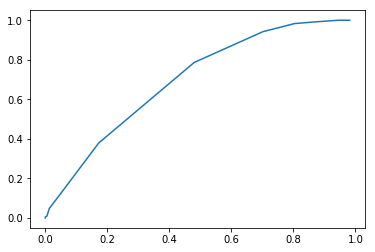

In [636]:
#Let's get our results using this set of words!
test_logits = []

for reviews in test_data:
    
    #Goes through each review and creates logits from the expanded lexicon set
    curr_logit = 0
    for word in reviews:
        #All words are weighted equally
        if word in positive_seeds:
            curr_logit += 1
        if word in negative_seeds:
            curr_logit -= 1
    test_logits.append(curr_logit)

lexicon_expansion_acc,lexicon_expansion_roc = get_results(test_logits)
print("Accuracy is {}".format(lexicon_expansion_acc))
plt.plot(lexicon_expansion_roc[:,1],lexicon_expansion_roc[:,0])

### Top 1000 Words, Vectors, Scoring

    -We're going to be doing a few things, starting with selecting the most frequent 1000 words.
    -We can start with a little bit of scoring with association on the training set.
    -Then we'll do a little bit with average vectors and basic NN models.
    -Then we'll do an RNN with One-hot vectors.

In [52]:
#We're going to go through our training set and identify the 1,000 most common words
words = []
counts = []
tracker = 0
num_top_words = 1000

for item in training_data:
    tracker += 1
    for word in item[0]:
        
        if word in words:
            counts[words.index(word)] += 1
        else:
            words.append(word)
            counts.append(1)
    if tracker%100 == 0:
        print(tracker/len(training_data))

#Getting top list
np_counts = np.asarray(counts)
top_counts = np.argsort(np_counts)[-1000:]
final_words = [words[i] for i in top_counts]

0.08333333333333333
0.16666666666666666
0.25
0.3333333333333333
0.4166666666666667
0.5
0.5833333333333334
0.6666666666666666
0.75
0.8333333333333334
0.9166666666666666
1.0


In [243]:
#Let's do an associative scoring of each word and see how that works
ass_count = np.ones((2,num_top_words))

for item in training_data:
    
    for word in item[0]:
        if word in final_words:
            
            #We count how many times each word is associated with each class
            if item[1] == 'pos':
                ass_count[0,final_words.index(word)] += 1
            else:
                ass_count[1,final_words.index(word)] += 1

#let's log and norm our values
#Ratio is the negative to positive ratio
ratio = sum(ass_count[1])/sum(ass_count[0])
associative_score = np.log(ratio * ass_count[0]/ass_count[1])/(ass_count[0] + ass_count[1])

Accuracy is 0.7799999999999889


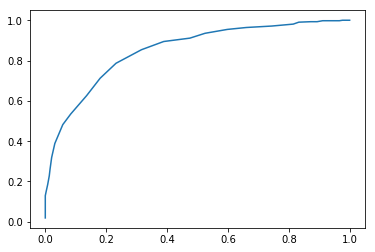

In [246]:
#Let's use our association scoring to predict the classification of our 
test_logits = []

for reviews in test_data:
    
    #Goes through each review and creates logits from the expanded lexicon set
    curr_logit = 0
    for word in reviews:
        #All words are weighted equally
        if word in final_words:
            curr_logit += associative_score[final_words.index(word)]
            
    test_logits.append(curr_logit)
associative_acc,_,_ = form_roc(test_logits)
_,associative_roc = get_results(test_logits)
print("Accuracy is {}".format(associative_acc))
plt.plot(associative_roc[:,1],associative_roc[:,0])

In [286]:
#Let's create one-hot vectors of our training and test set

ohv_training = []
for item in training_data:

    #Each item is an array, rows of one-hot vectors
    curr_review = np.zeros((len(item[0]),num_top_words))

    for count, word in enumerate(item[0]):
        if word in final_words:
            curr_review[count,final_words.index(word)] += 1

    ohv_training.append((curr_review,item[1]))


ohv_test = []
for review in test_data:
    
    #Each item is an array, rows of one-hot vectors
    curr_review = np.zeros((len(review),num_top_words))
    
    for count, word in enumerate(review):
        if word in final_words:
            curr_review[count,final_words.index(word)] += 1
    
    ohv_test.append(curr_review)

In [287]:
#We want to form data points for our algorithms
#The majority will not be using the ohv's in their current form
def stack_data(data):
    return np.sum(data, axis=0)/len(data)

ohv_train_data = np.zeros((len(ohv_training),num_top_words))
ohv_train_labels = np.zeros(len(ohv_training))

for ind, item in enumerate(ohv_training):
    ohv_train_data[ind] = stack_data(item[0])
    if item[1] == 'pos':
        ohv_train_labels[ind] = 1
    else:
        ohv_train_labels[ind] = -1

ohv_test_data = np.zeros((len(ohv_test),num_top_words))

for ind, item in enumerate(ohv_test):
    ohv_test_data[ind] = stack_data(item)

C:\Users\Zenaardvark\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


Accuracy is 0.6712499999999912


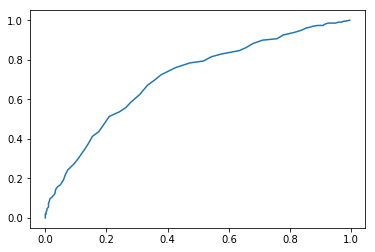

In [289]:
# Basic Regression Algorithm (Linear Least Squares)

#We'll just be using the numpy basic regression
out_mult = np.linalg.lstsq(ohv_train_data,ohv_train_labels)

test_logits = np.dot(ohv_test_data,out_mult[0])

regression1000_acc,_,_ = form_roc(test_logits)
_,regression1000_roc = get_results(test_logits)
print("Accuracy is {}".format(regression1000_acc))
plt.plot(regression1000_roc[:,1],regression1000_roc[:,0])

Accuracy is 0.7712499999999891


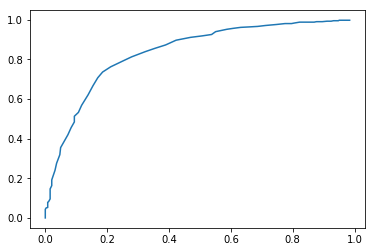

In [679]:
# SVM Method
from sklearn import svm

clf = svm.SVC(kernel='rbf', C=1000000)
clf.fit(ohv_train_data,ohv_train_labels)
outcome = clf.decision_function(ohv_test_data)

svm1000_acc,_,_ = form_roc(outcome)
_,svm1000_roc = get_results(outcome)
print("Accuracy is {}".format(svm1000_acc))
plt.plot(svm1000_roc[:,1],svm1000_roc[:,0])

In [549]:
#Basic Parameters
iterations = 10000
batch_size = 50

#Batch Retrieval
def basicNN_batch(data_set,label_set):
    samples = np.random.choice(len(data_set),batch_size,replace=False)
    Xs = []
    Ys = []
    for sample in samples:
        Xs.append(np.asarray(data_set[sample]))
        if label_set[sample] == -1:
            Ys.append([0])
        else:
            Ys.append([1])
    return {X: Xs, y: Ys}

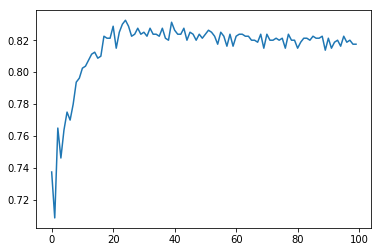

In [552]:
tf.reset_default_graph()

# Placeholders for input
X = tf.placeholder(tf.float32, [None, num_top_words])
y = tf.placeholder(tf.float32, [None, 1])

# Two-layer MLP
lay1_out = tf.layers.dense(X, 50, tf.nn.relu)
logits = tf.layers.dense(lay1_out, 1)

# Training
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))
train_step = tf.train.AdamOptimizer().minimize(loss)

# Initialization of variables
initialize_all = tf.global_variables_initializer() 

sess = tf.Session()
sess.run(initialize_all)

test_acc = []
for i in range(iterations):
    curr_batch = basicNN_batch(ohv_train_data,ohv_train_labels)
    sess.run(train_step, feed_dict=curr_batch)
    
    if (i+1)%100 == 0:
        out_logits = sess.run(logits, feed_dict={X: ohv_test_data})
        acc,_,_ = form_roc(out_logits)
        test_acc.append(acc)
plt.plot(test_acc)

Accuracy is 0.823749999999988


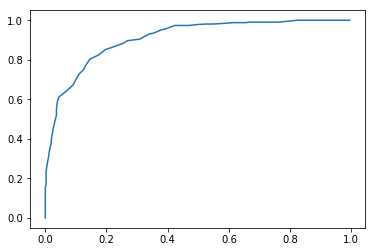

In [393]:
#Results for NN on one-hot vector
test_logits = sess.run(logits, feed_dict={X: ohv_test_data})
sess.close()

NN1000_acc,_,_ = form_roc(test_logits)
_,NN1000_roc = get_results(test_logits)
print("Accuracy is {}".format(NN1000_acc))
plt.plot(NN1000_roc[:,1],NN1000_roc[:,0])

In [557]:
# Some RNN
iterations = 5000

# sizes
n_steps = None
n_inputs = num_top_words
n_neurons = 50

# RNN batch
def RNN_batch(data_set):
    rand_ind = np.random.randint(0,len(data_set))
    review = data_set[rand_ind]
    
    outcome = np.array([0]).reshape([-1,1])
    if review[1] == 'pos':
        outcome = np.array([1]).reshape([-1,1])
    
    return {X: review[0].reshape([1,-1,n_inputs]), y: outcome}

In [558]:
tf.reset_default_graph()

# Build RNN
X= tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y= tf.placeholder(tf.float32, [None, 1])

basic_cell = tf.contrib.rnn.LSTMCell(n_neurons,activation=tf.nn.tanh)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
last_cell_output=outputs[:,-1,:]
y_=tf.layers.dense(last_cell_output,1)

# Loss and metrics
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_, labels=y))

# Training
train_step = tf.train.AdamOptimizer().minimize(loss)

initialize_all = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initialize_all)

for i in range(iterations):
    curr_batch = RNN_batch(ohv_training)
    sess.run(train_step, feed_dict=curr_batch)
    
    if (i+1)%500 == 0:
        print(i/iterations)

0.0998
0.1998
0.2998
0.3998
0.4998
0.5998
0.6998
0.7998
0.8998
0.9998


0.0
0.125
0.25
0.375
0.5
0.625
0.75
0.875
Accuracy is 0.5674999999999935 and best accuracy is 0.591249999999993


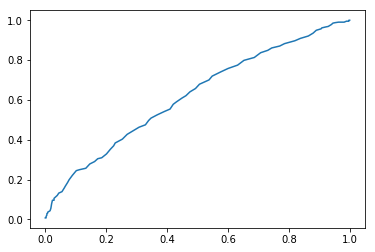

In [559]:
test_logits = []
for count, ohvs in enumerate(ohv_test):
    
    test_logits.append(sess.run(y_, feed_dict={X: ohvs.reshape([1,-1,n_inputs])}))
    
    if count % 100 == 0:
        print(count/len(ohv_test))

RNN1000_acc,_,_ = form_roc(test_logits)
best_RNN1000_acc,RNN1000_roc = get_results(test_logits)
print("Accuracy is {} and best accuracy is {}".format(RNN1000_acc,best_RNN1000_acc))
plt.plot(RNN1000_roc[:,1],RNN1000_roc[:,0])
#sess.close()

In [423]:
RNN1000_acc,_ = get_results(test_logits)
print("Best accuracy is {}".format(RNN1000_acc))

Best accuracy is 0.5824999999999931


### Word Embeddings

    - We're going to use a lot of the same techniques, but with word embeddings.
    - First, we're going to use our list from before and identify some embedded associated words (instead of lexicon)
    - Then we're going to apply the same NN techniques from before, but with embeddings

In [443]:
import gensim

#We're going to use the google news dataset which already has its embeddings pretty well developed
nltk.download('word2vec_sample')
from nltk.data import find
google_model = str(find('models/word2vec_sample/pruned.word2vec.txt'))
emb_model = gensim.models.KeyedVectors.load_word2vec_format(google_model, binary=False)

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     C:\Users\Zenaardvark\AppData\Roaming\nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


In [637]:
#Let's get some associated words from the brown corpus
good_words = ["excellent","interesting","perfect","impeccable","exhilarating"]
bad_words = ["boring","unimaginative","terrible","bad","embarrassing"]

num_additional_seeds = 95

In [638]:
#Simply uses word embeddings to track down the closest additional words in word space
#I also do negative connotation with the bad words
positive_seeds = good_words
negative_seeds = bad_words

most_similars = emb_model.most_similar(positive=good_words,negative=bad_words,topn=num_additional_seeds)
for sim in most_similars:
    positive_seeds.append(sim[0])
    
most_similars = emb_model.most_similar(positive=bad_words,negative=good_words,topn=num_additional_seeds)
for sim in most_similars:
    negative_seeds.append(sim[0])
    
print(positive_seeds)
print(negative_seeds)

C:\Users\Zenaardvark\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['excellent', 'interesting', 'perfect', 'impeccable', 'exhilarating', 'unmatched', 'superb', 'unparalleled', 'exceptional', 'unsurpassed', 'unique', 'unequaled', 'incomparable', 'exquisite', 'ideal', 'versatility', 'optimum', 'effortless', 'exciting', 'matchless', 'enviable', 'peerless', 'incredible', 'elegant', 'impressive', 'terrific', 'splendid', 'distinctive', 'invaluable', 'immaculate', 'integral', 'marvelous', 'magnificent', 'optimal', 'fantastic', 'complements', 'complement', 'expertly', 'seamless', 'elegance', 'superlative', 'phenomenal', 'beautifully', 'superbly', 'Complementing', 'renowned', 'topnotch', 'unforgettable', 'amazing', 'finest', 'captivating', 'delightful', 'fabulous', 'remarkable', 'dynamic', 'unerring', 'artistry', 'authentic', 'excellently', 'pianism', 'wonderful', 'flawless', 'combines', 'enjoys', 'outstanding', 'faultless', 'impeccably', 'superior', 'virtuosity', 'complementary', 'instrumental', 'pianistic', 'sumptuous', 'enchanting', 'versatile', 'masterful'

Accuracy is 0.6962499999999907


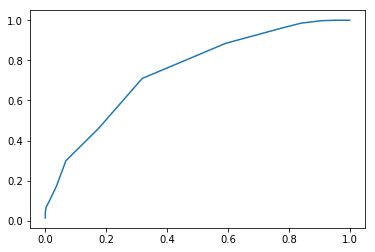

In [639]:
#Let's get our results using embeddings
test_logits = []

for reviews in test_data:
    
    #Goes through each review and creates logits from the expanded lexicon set
    curr_logit = 0
    for word in reviews:
        #All words are weighted equally
        if word in positive_seeds:
            curr_logit += 1
        if word in negative_seeds:
            curr_logit -= 1
    test_logits.append(curr_logit)

embedded_expansion_acc,embedded_expansion_roc = get_results(test_logits)
print("Accuracy is {}".format(embedded_expansion_acc))
plt.plot(embedded_expansion_roc[:,1],embedded_expansion_roc[:,0])

### Word Embeddings in Models

    -Let's form our Word Embedding Functions

In [498]:
#Let's make a training and test set using the word embeddings
#We will be use all the words in each set, so no top 1000 list
emb_size = len(emb_model['the'])

emb_training = []
for item in training_data:
    #Each item is an array, row embeddings
    curr_review = np.zeros((len(item[0]),emb_size))

    for count, word in enumerate(item[0]):
        if word in emb_model.vocab:
            curr_review[count] = emb_model[word]

    emb_training.append((curr_review,item[1]))


emb_test = []
for review in test_data:
    
    #Each item is an array, rows of one-hot vectors
    curr_review = np.zeros((len(review),emb_size))
    
    for count, word in enumerate(review):
        if word in emb_model.vocab:
            curr_review[count] = emb_model[word]
    
    emb_test.append(curr_review)

In [501]:
#Forming Data points for 
emb_train_data = np.zeros((len(emb_training),emb_size))
emb_train_labels = np.zeros(len(emb_training))

for ind, item in enumerate(emb_training):
    emb_train_data[ind] = stack_data(item[0])
    if item[1] == 'pos':
        emb_train_labels[ind] = 1
    else:
        emb_train_labels[ind] = -1

emb_test_data = np.zeros((len(emb_test),emb_size))

for ind, item in enumerate(emb_test):
    emb_test_data[ind] = stack_data(item)

Accuracy is 0.8049999999999884


C:\Users\Zenaardvark\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


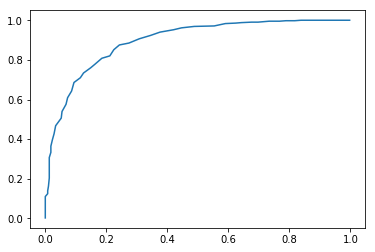

In [503]:
# Some Regression Algorithm with embedded
out_mult = np.linalg.lstsq(emb_train_data,emb_train_labels)

test_logits = np.dot(emb_test_data,out_mult[0])

regressionEMB_acc,_,_ = form_roc(test_logits)
_,regressionEMB_roc = get_results(test_logits)
print("Accuracy is {}".format(regressionEMB_acc))
plt.plot(regressionEMB_roc[:,1],regressionEMB_roc[:,0])

Accuracy is 0.8287499999999879


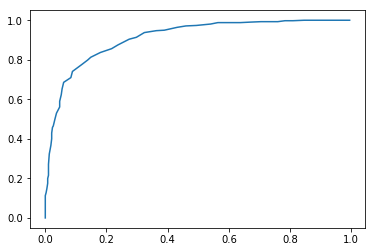

In [690]:
#Using SVM again
clf = svm.SVC(kernel='rbf', C=100000)
emb_train_labels[emb_train_labels == -1] = 0
clf.fit(emb_train_data,emb_train_labels)
outcome = clf.decision_function(emb_test_data)

svmEMB_acc,_,_ = form_roc(outcome)
_,svmEMB_roc = get_results(outcome)
print("Accuracy is {}".format(svmEMB_acc))
plt.plot(svmEMB_roc[:,1],svmEMB_roc[:,0])

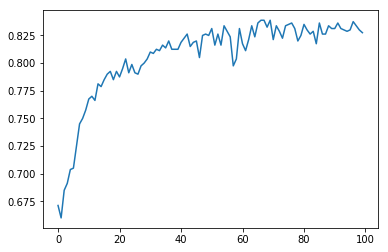

In [554]:
iterations = 10000

# Again, let's set up a NN.  
tf.reset_default_graph()

# Placeholders for input
X = tf.placeholder(tf.float32, [None, emb_size])
y = tf.placeholder(tf.float32, [None, 1])

# Two-layer MLP
lay1_out = tf.layers.dense(X, 50, tf.nn.relu)
logits = tf.layers.dense(lay1_out, 1)

# Training
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))
train_step = tf.train.AdamOptimizer().minimize(loss)

# Initialization of variables
initialize_all = tf.global_variables_initializer() 

sess = tf.Session()
sess.run(initialize_all)

emb_test_acc = []
for i in range(iterations):
    
    # We can use the same batch function as before.
    curr_batch = basicNN_batch(emb_train_data,emb_train_labels)
    sess.run(train_step, feed_dict=curr_batch)
    
    if (i+1)%100 == 0:
        out_logits = sess.run(logits, feed_dict={X: emb_test_data})
        acc,_,_ = form_roc(out_logits)
        emb_test_acc.append(acc)
plt.plot(emb_test_acc)

Accuracy is 0.8349999999999878


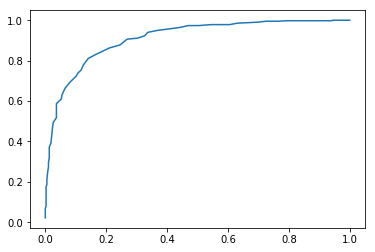

In [540]:
test_logits = sess.run(logits, feed_dict={X: emb_test_data})

NNEMB_acc,_,_ = form_roc(test_logits)
_,NNEMB_roc = get_results(test_logits)
print("Accuracy is {}".format(NNEMB_acc))
plt.plot(NNEMB_roc[:,1],NNEMB_roc[:,0])

In [701]:
tf.reset_default_graph()
#Parameters
iterations = 5000
# sizes
n_steps = None
n_inputs = emb_size
n_neurons = 50

# Build RNN
X= tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y= tf.placeholder(tf.float32, [None, 1])

basic_cell = tf.contrib.rnn.LSTMCell(n_neurons,activation=tf.nn.tanh)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
last_cell_output=outputs[:,-1,:]
y_=tf.layers.dense(last_cell_output,1)

# Loss and metrics
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_, labels=y))

# Training
train_step = tf.train.AdamOptimizer().minimize(loss)

initialize_all = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initialize_all)

for i in range(iterations):
    curr_batch = RNN_batch(emb_training)
    sess.run(train_step, feed_dict=curr_batch)
    
    if (i+1)%500 == 0:
        print(i/iterations)

0.0998
0.1998
0.2998
0.3998
0.4998
0.5998
0.6998
0.7998
0.8998
0.9998


0.0
0.125
0.25
0.375
0.5
0.625
0.75
0.875
Accuracy is 0.7099999999999904 and best accuracy is 0.7262499999999901


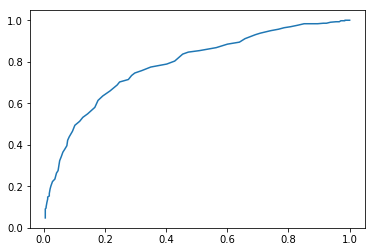

In [702]:
test_logits = []
for count, emb in enumerate(emb_test):
    
    test_logits.append(sess.run(y_, feed_dict={X: emb.reshape([1,-1,n_inputs])}))
    
    if count % 100 == 0:
        print(count/len(emb_test))

EMBRNN_acc,_,_ = form_roc(test_logits)
best_EMBRNN_acc,EMBRNN_roc = get_results(test_logits)
print("Accuracy is {} and best accuracy is {}".format(EMBRNN_acc,best_EMBRNN_acc))
plt.plot(EMBRNN_roc[:,1],EMBRNN_roc[:,0])
sess.close()

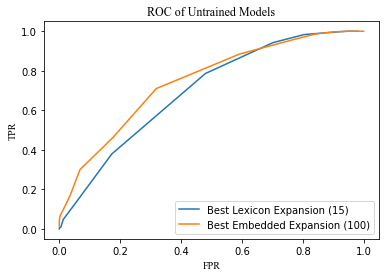

In [642]:
#Save Independent Methods
csfont = {'fontname':'Times New Roman'}
plt.plot(lexicon_expansion_roc[:,1],lexicon_expansion_roc[:,0], label='Best Lexicon Expansion (15)')
plt.plot(embedded_expansion_roc[:,1],embedded_expansion_roc[:,0], label='Best Embedded Expansion (100)')
plt.title('ROC of Untrained Models', **csfont)
plt.legend()
plt.xlabel('FPR', **csfont)
plt.ylabel('TPR', **csfont)
plt.savefig("Untrained_Models.png",dpi=300)

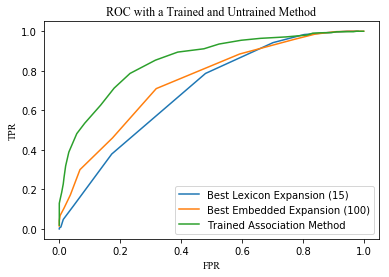

In [643]:
#Save Independent vs. Dependent Methods
csfont = {'fontname':'Times New Roman'}
plt.plot(lexicon_expansion_roc[:,1],lexicon_expansion_roc[:,0], label='Best Lexicon Expansion (15)')
plt.plot(embedded_expansion_roc[:,1],embedded_expansion_roc[:,0], label='Best Embedded Expansion (100)')
plt.plot(associative_roc[:,1],associative_roc[:,0], label='Trained Association Method')
plt.title('ROC with a Trained and Untrained Method', **csfont)
plt.legend()
plt.xlabel('FPR', **csfont)
plt.ylabel('TPR', **csfont)
plt.savefig("Trained_vs_Untrained.png",dpi=300)

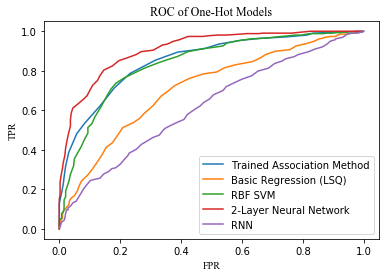

In [694]:
#Different Training Models - OHV
csfont = {'fontname':'Times New Roman'}
plt.plot(associative_roc[:,1],associative_roc[:,0], label='Trained Association Method')
plt.plot(regression1000_roc[:,1],regression1000_roc[:,0], label='Basic Regression (LSQ)')
plt.plot(svm1000_roc[:,1],svm1000_roc[:,0], label='RBF SVM')
plt.plot(NN1000_roc[:,1],NN1000_roc[:,0], label='2-Layer Neural Network')
plt.plot(RNN1000_roc[:,1],RNN1000_roc[:,0], label='RNN')
plt.title('ROC of One-Hot Models', **csfont)
plt.legend()
plt.xlabel('FPR', **csfont)
plt.ylabel('TPR', **csfont)
plt.savefig("OneHot_models.png",dpi=300)

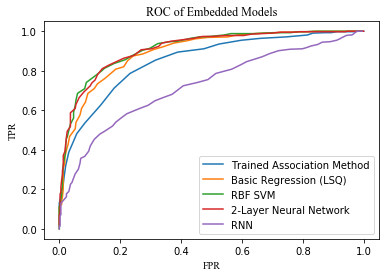

In [695]:
#Different Training Models - Embedded
csfont = {'fontname':'Times New Roman'}
plt.plot(associative_roc[:,1],associative_roc[:,0], label='Trained Association Method')
plt.plot(regressionEMB_roc[:,1],regressionEMB_roc[:,0], label='Basic Regression (LSQ)')
plt.plot(svmEMB_roc[:,1],svmEMB_roc[:,0], label='RBF SVM')
plt.plot(NNEMB_roc[:,1],NNEMB_roc[:,0], label='2-Layer Neural Network')
plt.plot(EMBRNN_roc[:,1],EMBRNN_roc[:,0], label='RNN')
plt.title('ROC of Embedded Models', **csfont)
plt.legend()
plt.xlabel('FPR', **csfont)
plt.ylabel('TPR', **csfont)
plt.savefig("Embedded_models.png",dpi=300)

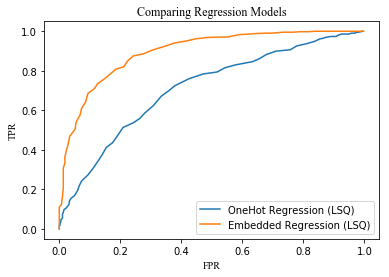

In [697]:
csfont = {'fontname':'Times New Roman'}
plt.plot(regression1000_roc[:,1],regression1000_roc[:,0], label='OneHot Regression (LSQ)')
plt.plot(regressionEMB_roc[:,1],regressionEMB_roc[:,0], label='Embedded Regression (LSQ)')
plt.title('Comparing Regression Models', **csfont)
plt.legend()
plt.xlabel('FPR', **csfont)
plt.ylabel('TPR', **csfont)
plt.savefig("Regressions.png",dpi=300)

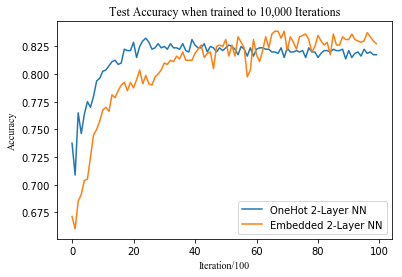

In [699]:
csfont = {'fontname':'Times New Roman'}
plt.plot(test_acc, label='OneHot 2-Layer NN')
plt.plot(emb_test_acc, label='Embedded 2-Layer NN')
plt.title('Test Accuracy when trained to 10,000 Iterations', **csfont)
plt.legend()
plt.xlabel('Iteration/100', **csfont)
plt.ylabel('Accuracy', **csfont)
plt.savefig("NN_training.png",dpi=300)

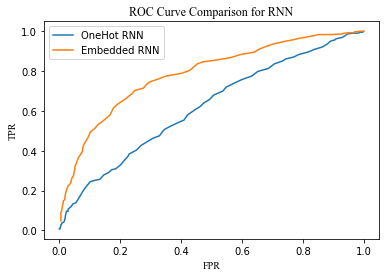

In [703]:
csfont = {'fontname':'Times New Roman'}
plt.plot(RNN1000_roc[:,1],RNN1000_roc[:,0], label='OneHot RNN')
plt.plot(EMBRNN_roc[:,1],EMBRNN_roc[:,0], label='Embedded RNN')
plt.title('ROC Curve Comparison for RNN', **csfont)
plt.legend()
plt.xlabel('FPR', **csfont)
plt.ylabel('TPR', **csfont)
plt.savefig("RNN_ROC.png",dpi=300)